## Setup

In [ ]:
# Importing the main libraries
import numpy as np
import pandas as pd

# Notebook settings
%matplotlib inline

# Importing data visualization libraries
import plotly.express as px
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

# Data visualization settings
sns.set_style("whitegrid")

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

## Overview

In [ ]:
# Loading the first dataset
df = pd.read_csv('/kaggle/input/housing-in-london/housing_in_london_monthly_variables.csv')

In [ ]:
# Checking the dataset variables
df.info()

In [ ]:
# Viewing a sample of the dataset
df.head()

In [ ]:
# Showing min and max dates
print(df['date'].min())
print(df['date'].max())

In [ ]:
# Viewing the available areas in the dataset that aren't london boroughs
df[df['borough_flag'] == 0]['area'].unique()

In [ ]:
# Viewing the london boroughs
df[df['borough_flag'] == 1]['area'].unique()

## Exploratory Data Analysis

#### How many houses were sold in London over time?

In [ ]:
# Converting the date variable to a date object
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Now let's see the number of houses sold in London over time
houses_sold_london = df[df['area'] == 'london'] \
                       .groupby('date')['houses_sold'] \
                       .sum() \
                       .reset_index() \
                       .rename(columns={'date':'Date', 'houses_sold':'Houses Sold'})
houses_sold_london

In [ ]:
# Let's plot the information above in the past two decades
fig = px.line(houses_sold_london[(houses_sold_london['Date'] >= '2000-01-01') & \
             (houses_sold_london['Date'] < '2019-12-01')],
              x="Date", y="Houses Sold",
              template='seaborn', title='Sold Houses in London')

fig

From this plot, the two things that most grabs our attention is the sharp decrease occured in the 2007-2008 period and the unusual surge that occured in March/2016. From a search on Google we can see that:

1. The Sharp decrease seen in the 2007-2008 period was due to the global financial crisis.
2. The surge in March/2016 occured because of a rush to beat an increase in the tax bill on buying a second home, that came into effect in April/2016.

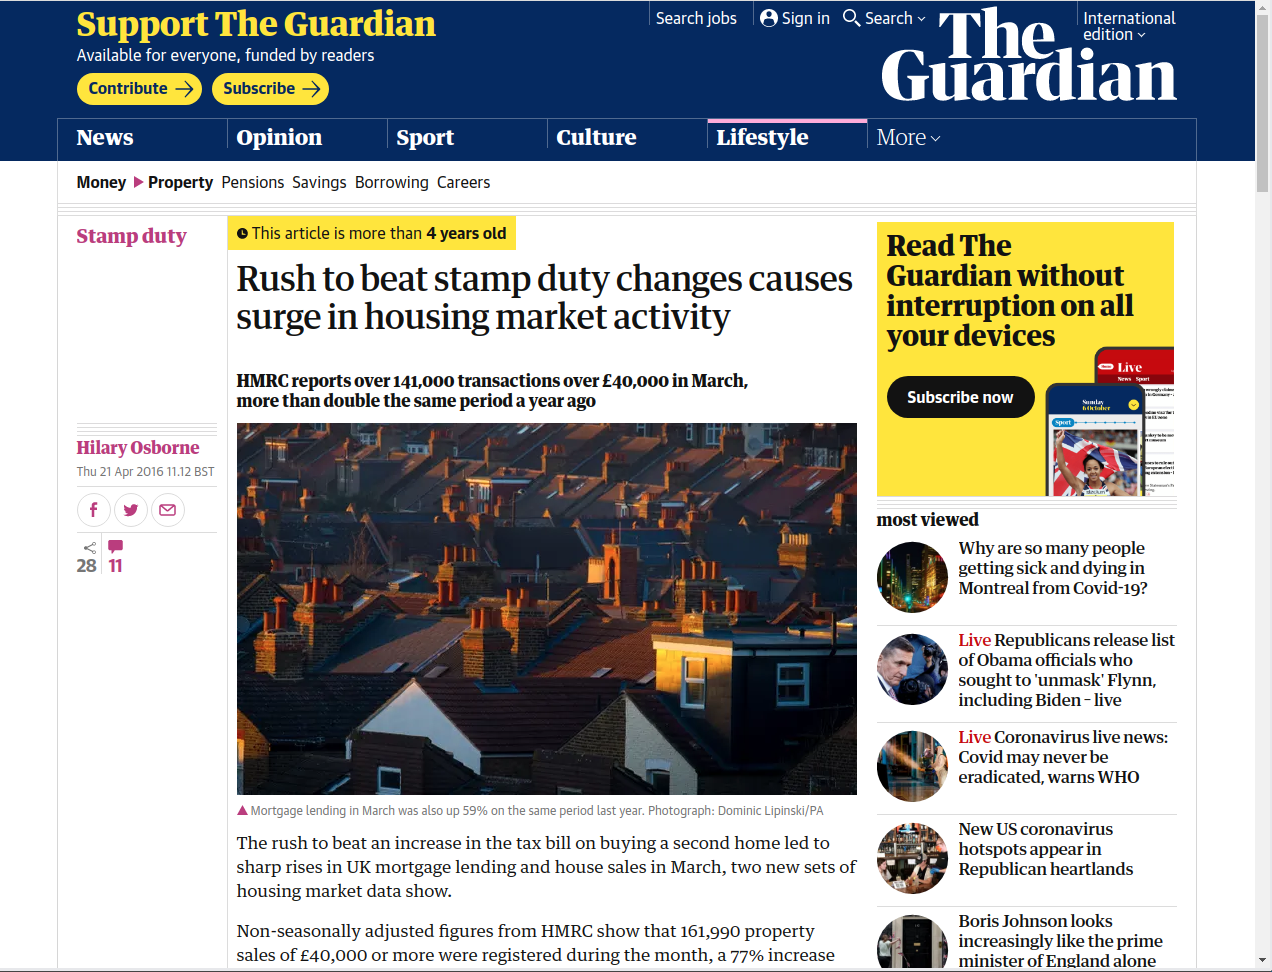

In [ ]:
# In order to represent this events, we can plot them in the graph below
fig.add_shape( # Shape representing the decrease
    type="rect",
    xref="x",
    yref="paper",
    x0="2007-08-01",
    y0=0,
    x1="2009-02-01",
    y1=1,
    fillcolor="lightpink",
    opacity=0.5,
    layer="below",
    line_width=0,
)

fig.add_shape( # Shape representing the surge
    type="rect",
    xref="x",
    yref="paper",
    x0="2016-02-01",
    y0=0,
    x1="2016-04-01",
    y1=1,
    fillcolor="lightgreen",
    opacity=0.5,
    layer="below",
    line_width=0
)

We can also see with the plot that the average number of houses sold monthly in the first decade is higher than in the second decade. So let's confirm that.

In [ ]:
# Getting the avg for each decade and plotting in the graph
avg_first_decade = houses_sold_london[(houses_sold_london['Date'] >= '2000-01-01') & \
                                      (houses_sold_london['Date'] <= '2009-12-01')]['Houses Sold'] \
                                      .mean()

avg_first_decade = round(avg_first_decade, 0)

fig.add_shape( # add a horizontal line, representing the avg in the first decade
    type="line", line_color="coral", line_width=2, opacity=1, line_dash="dot",
    x0=0, x1=1, xref="paper", y0=avg_first_decade,
    y1=avg_first_decade, yref="y"
)

fig.add_annotation( # add a text 
    text="2000s average", x='2020-01-01', y=12000 
)

avg_second_decade = houses_sold_london[(houses_sold_london['Date'] >= '2010-01-01') & \
                                      (houses_sold_london['Date'] <= '2019-12-01')]['Houses Sold'] \
                                      .mean()

avg_second_decade = round(avg_second_decade, 0)

fig.add_shape( # add a horizontal line, representing the avg in the second decade
    type="line", line_color="darkcyan", line_width=2, opacity=1, line_dash="dash",
    x0=0, x1=1, xref="paper", y0=avg_second_decade,
    y1=avg_second_decade, yref="y",  
)

fig.add_annotation( # add a text 
    text="2010s average", x='2020-01-01', y=8300 
)

From the plot above we see that the average monthly sales in the 2000s decade (~ 11950 sales/month) was 44% higher than in the second decade of the century (~ 8260 sales/month), showing that the market didn't recover to pre-crisis levels.

#### How the average house price behave in the same period? How did it behave in the other regions?

In [ ]:
# First, let's create a new dataframe with the required information for the plot
avg_price_df = df[df['area'].isin(['south east', 'north east', 'north west',
                                    'yorks and the humber', 'east midlands', 
                                    'east of england', 'london', 'south west', 'west midlands'])] \
                            .filter(['date','area','average_price']) \
                            .rename(columns={'date':'Date','area':'Region','average_price':'Average Price'}) \
                            .sort_values(by='Date')

avg_price_df

In [ ]:
# Let's plot the information above in the past two decades
px.line(avg_price_df[(avg_price_df['Date'] >= '2000-01-01') & \
       (avg_price_df['Date'] < '2019-12-01')],
        x="Date", y="Average Price", color="Region",
        template='seaborn', title='Average House Price in England by Region')


From observing the plot, we see that London had a higher average price in the past two decades, followed by the Southeast and the East of England regions. We can say that it seems that the regions had a similar trend regarding house prices in the period. The most visible exception is London, that appears to have had a higher growth rate compared to the other regions in the period from January/2013 to July/2016. So let's confirm that by plotting a map.

In [ ]:
# First we need to calculate the growth rate between the two periods for all the regions
growth_rate_df = avg_price_df[avg_price_df['Date'].isin(['2013-01-01','2016-07-01'])] \
                             .pivot(index='Region', columns='Date', values='Average Price') \
                             .rename(columns=lambda t: t.strftime('%Y-%m')) \
                             .reset_index() \
                             .rename(columns={'2013-01':'P1','2016-07':'P2'}) \
                             .eval('GR=((P2-P1)/P1)*100') \
                             .rename(columns={'GR':'Growth Rate'}) \
                             .round({'Growth Rate': 2})

In [ ]:
# Loading the map file containing England's regions with the geopandas library
england_map = gpd.read_file("https://github.com/martinjc/UK-GeoJSON/blob/master/json/electoral/eng/eer.json?raw=truen")
england_map.head(10)

In [ ]:
# Standardizing the regions' names and merging them in a unique dataframe
growth_rate_df['Region'] = growth_rate_df['Region'].str.title()
growth_rate_df['Region'] = growth_rate_df['Region'].replace({'Yorks And The Humber':'Yorkshire and The Humber', 
                                                             'East Of England':'East of England'})
england_map['EER13NM'] = england_map['EER13NM'].replace({'Eastern':'East of England'})

merged_df = pd.merge(england_map, growth_rate_df, how='left', left_on='EER13NM', right_on='Region')
merged_df.head(10)

In [ ]:
# Now, we can use the folium library to plot an interactive choropleth map

# Setting the coordinates for the map
growth_rate_map = folium.Map(location=[52.6033, -1.4183], zoom_start=6)

# Creating the choropleth layer
choropleth = folium.Choropleth(merged_df, data=merged_df,
                  key_on='feature.properties.Region',
                  columns=['Region', 'Growth Rate'], 
                  fill_color='Reds', fill_opacity = 1,
                  line_opacity=0.3, highlight=True,
                  name='England', legend_name='% Growth Rate - Jan/13 to Jul/16').add_to(growth_rate_map)

# Adding the layers to the map
folium.LayerControl().add_to(growth_rate_map)

# Adding the tooltip to the map
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['Region','Growth Rate'])
)

# Displaying the map
growth_rate_map

Analyzing the plot above, we confirmed that London had the highest growth rate (~ 53%) among all the regions in the period.

#### How many houses were sold in London by Borough?

First we will see how many houses were sold in each borough in the past two decades.

In [ ]:
# Loading the geojson file containing the city boroughs with the geopandas library
london_map = gpd.read_file('https://skgrange.github.io/www/data/london_boroughs.json')

In [ ]:
# Creating a dataframe with the data to be used in the map
borough_df = df[(df['borough_flag'] == 1) & (df['date'] >= '2000-01-01') & (df['date'] <= '2019-12-01')] \
               .groupby('area')['houses_sold'] \
               .sum() \
               .reset_index() \
               .rename(columns={'area':'Borough','houses_sold':'Houses Sold'})

In [ ]:
# Merging the dataframe with the dataframe containing geographical information
london_map['name'] = london_map['name'].str.lower()

borough_map = pd.merge(london_map, borough_df, how='left', left_on='name', right_on='Borough')
borough_map.head()

In [ ]:
# Now, in the same way as we did with the growth rate map, we can plot the borough map
# Setting the coordinates for the map
houses_sold_borough_map = folium.Map(location=[51.509865,  -0.118092], zoom_start=10)

# Creating the choropleth layer
choropleth_borough = folium.Choropleth(borough_map, data=borough_map,
                     key_on='feature.properties.Borough',
                     columns=['Borough', 'Houses Sold'], 
                     fill_color='Blues', fill_opacity = 1, bins=8,
                     line_opacity=0.3, highlight=True, 
                     name='Houses Sold', legend_name='# Houses Sold').add_to(houses_sold_borough_map)

# Adding the layers to the map
folium.LayerControl().add_to(houses_sold_borough_map)

# Adding the tooltip to the map
choropleth_borough.geojson.add_child(
    folium.features.GeoJsonTooltip(['Borough','Houses Sold'])
)

# Displaying the map
houses_sold_borough_map

Now, let's see how those sales occured over time.

In [ ]:
# We will plot a heatmap in order to show this information
# Data for the plot
byYearBorough_df = df.copy()

byYearBorough_df['Year'] = byYearBorough_df['date'].dt.year

byYearBorough_df = byYearBorough_df[(byYearBorough_df['Year'] >= 2000) & (byYearBorough_df['Year'] <= 2019) & \
                                    (byYearBorough_df['borough_flag'] == 1)] \
                                   .groupby(['Year','area'])['houses_sold'] \
                                   .sum() \
                                   .reset_index() \
                                   .rename(columns={'area':'Borough','houses_sold':'Houses Sold'})

byYearBorough_df = pd.pivot_table(data=byYearBorough_df,values='Houses Sold',index='Borough',
                                  columns='Year',aggfunc='sum')

# Plot
plt.figure(figsize=(15,8))
sns.heatmap(data = byYearBorough_df, cmap='viridis', linecolor='grey', linewidth=0.2)
plt.title('Houses Sold in London by Borough \n2000-2019')

From both plots above, we can see that the boroughs with the highest number of houses sold in the period were **Wandsworth**, **Bromley** and **Croydon**. Besides that, looking into the heatmap we can say that boroughs that had the most positive results in the pre-crisis period continued to show good results in the 2010s compared to the other boroughs. 

#### How many houses were sold in Inner and Outer London areas? What about the average price in both regions?

In [ ]:
# Plotting sold houses and average prices between Inner and Outer London areas
inner_outer_df = df[(df['area'].isin(['inner london','outer london'])) & (df['date'].dt.year >= 2000) & (df['date'].dt.year <= 2019)] \
                   .groupby(['date','area'])['houses_sold','average_price'] \
                   .agg({'houses_sold':'sum','average_price':'mean'}) \
                   .reset_index() \
                   .rename(columns={'date':'Date','area':'Area','houses_sold':'Houses Sold','average_price':'Average Price'}) \
                   .melt(id_vars=['Date','Area'])

fig = px.line(inner_outer_df, x='Date', y='value', color='Area', facet_row='variable',
              title = 'Sold Houses and Average Price - Inner and Outer London')

fig.update_yaxes(matches=None) # Allows the y axes on both facets to be independent from each other

From the plot above we see that Outer London had a higher number of houses sold and a lower average price in comparison to Inner London. Now let's explore the relationship between these two variables and other ones.

#### Relationship between number of houses sold and average price with another variables

In [ ]:
# Loading the second dataset
df_yearly = pd.read_csv('/kaggle/input/housing-in-london/housing_in_london_yearly_variables.csv')

In [ ]:
# Checking the dataset variables
df_yearly.info()

In [ ]:
# Viewing a sample of the dataset
df_yearly.head()

In [ ]:
# Data cleaning 

# Replacing incorrect strings in numeric columns
df_yearly.replace(['','-','#','na'], np.nan, inplace=True)

# Converting data types
df_yearly['mean_salary'] = df_yearly['mean_salary'].astype(float)
df_yearly['recycling_pct'] = df_yearly['recycling_pct'].astype(float)

As the granularity of the information presented in the datasets are differents, we have to aggregate the information in the monthly dataset.

In [ ]:
# Data preparation

# Aggregating the first dataset
df_aggregated = df.groupby([df['date'].dt.year,'area'])['houses_sold','average_price', 'no_of_crimes'] \
                  .agg({'houses_sold':'sum','average_price':'mean','no_of_crimes':'sum'}) \
                  .reset_index()

# Converting date in the second dataset
df_yearly['date'] = pd.to_datetime(df_yearly['date']).dt.year

# Merging the dataframes on date and area
consolidated_df = pd.merge(df_aggregated, df_yearly, how='inner', on=['date','area'])

# Viewing the result
consolidated_df.head()

Now we will plot a correlation matrix, to see if we can get some insights.

In [ ]:
# Plotting a correlation matrix
plt.figure(figsize=(15,8))
sns.heatmap(consolidated_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0,
            mask=np.triu(consolidated_df.corr()), cmap='cividis', )
plt.title('Correlation Matrix')

Observing the correlation matrix, we can draw some conclusions:

- The number of sold houses has an expected strong correlation to the size (area and number of houses) and the population of the area
- The number of sold houses also has a strong correlation to the number of jobs of the area, showing that the area's economy is a important determinant to this indicator
- The average price indicator has a high correlation to the median salary, or in other terms, the highest income a person has, the most expensive is the area she lives in

#### Bonus: Was the growth in the cost of living in London followed by a proper growth in income?

In [ ]:
plot_df = consolidated_df[(consolidated_df['area'] == 'london') & (df['date'] >= '2000-01-01') & (df['date'] <= '2019-12-01')] \
                         .filter(['date','average_price','median_salary']) \
                         .melt('date') \
                         .rename(columns={'date':'Date','variable':'Indicator','value':'Value'})
                             
vsPlot = px.line(plot_df, x='Date', y='Value', color='Indicator',
                 title = 'Cost of Living vs Income')

vsPlot.update_layout(yaxis_type="log", yaxis_title='Value (Log)')

Analyzing the plot above we can see that while the **median salary grew 61%** in the period, the **average price of a house in the city grew an astonishing 232%**